In [2]:
import time
import datetime
import os
import random
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import adabound

from trainer_helper import Trainer_Helper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(23)
torch.manual_seed(23)
if device == "cuda:0":
    torch.cuda.manual_seed(23)


In [3]:
data_dir = "UrbanSound8K/spectogram/"

num_classes = 10
batch_size = 32

We make sure that the images are exactly 224 because the output size of the plot from matplotlib varies by a few pixels.

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(data_dir + 'train/', data_transforms)
val_dataset = datasets.ImageFolder(data_dir + 'val/', data_transforms)
test_dataset = datasets.ImageFolder(data_dir + 'test/', data_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory =True, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

CNN Spectogram
==============

We will run different CNN on the spectograms created with *data_preparaation.ipynb*.

First we will try a very basic CNN to get a baseline. The we will try modified versions of ResNet and Densnet and evaluate whether these more advanced Neural Networks can get a higher accuracy.

Simple CNN
-----------

We define a simple CNN with 4 Convelutional Layers with BatchNorm and ReLUs.

In [5]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            # input.size: 3x224x224
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            # output: 16x224x224
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # output: 16x112x112


            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # output: 128x112x112
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 32x56x56


            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # output: 64x56x56
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # output: 64x56x56
            nn.ReLU(),
            nn.BatchNorm2d(64),            
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 64x28x28


            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # output: 64x14x14
            nn.ReLU(),
            nn.BatchNorm2d(64),            
            nn.AdaptiveAvgPool2d((1,1))
            # output: 256x7x7
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(64, 10)
        )

    def forward(self, input):
        output = self.conv_layers(input)
        output = output.view(input.size(0), -1)
        output = self.linear_layer(output)
        return output

We train the model with the brand new AdaBound optimizer for 30 epochs.

In [ ]:
model = ConvNet()

#run_name = datetime.datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
run_name = 'optim-adabound-lr0-001'

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
criterion = nn.CrossEntropyLoss()

trainer = Trainer_Helper(run_name, device)
trainer.setup_dataloader(train_dataloader, val_dataloader, test_dataloader)
trainer.train(model, optimizer, criterion, 30)

# Use a CosineAnnelingScheduler with SGD optimizer. Similar result as Adabound but much slower.
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#lr = 1e-3
#lr_handler = CosineAnnealingScheduler(optimizer, 'lr', lr, lr*100, len(train_dataloader), cycle_mult=2)
#trainer.add_event_handler(Events.ITERATION_COMPLETED, lr_handler)


Evaluation of the SimpleCNN:

In [7]:
correct = 0
total = 0

model = ConvNet()
model = model.to(device)

model_filepath = 'saved_models/simple_cnn_best_val=79_9.pth' #'models_checkpoints/optim-adabound_model_29_val_accuracy=79.90196.pth'

model.load_state_dict(torch.load(model_filepath))
model.eval()

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred.cpu() == labels).sum().item()

print('Test Accuracy: {}'.format(100.0*correct/total))

Test Accuracy: 81.83990442054959


ResNet and DenseNet
-------------------
Can we get a better accuracy by using much bigger Convolution Networks? We will use the pretrained versions comming with PyTorch since they train much faster (even though we don't have real images).

Training Results - Epoch: 1  Avg accuracy: 0.86 Avg loss: 0.39
Validation Results - Epoch: 1  Avg accuracy: 0.79 Avg loss: 0.70
Training Results - Epoch: 2  Avg accuracy: 0.95 Avg loss: 0.16
Validation Results - Epoch: 2  Avg accuracy: 0.80 Avg loss: 0.76
Training Results - Epoch: 3  Avg accuracy: 0.97 Avg loss: 0.10
Validation Results - Epoch: 3  Avg accuracy: 0.73 Avg loss: 0.92
Training Results - Epoch: 4  Avg accuracy: 0.97 Avg loss: 0.08
Validation Results - Epoch: 4  Avg accuracy: 0.80 Avg loss: 0.91
Training Results - Epoch: 5  Avg accuracy: 0.98 Avg loss: 0.06
Validation Results - Epoch: 5  Avg accuracy: 0.84 Avg loss: 0.85
Training Results - Epoch: 6  Avg accuracy: 0.98 Avg loss: 0.05
Validation Results - Epoch: 6  Avg accuracy: 0.85 Avg loss: 0.78
Training Results - Epoch: 7  Avg accuracy: 0.99 Avg loss: 0.03
Validation Results - Epoch: 7  Avg accuracy: 0.80 Avg loss: 1.05
Training Results - Epoch: 8  Avg accuracy: 1.00 Avg loss: 0.01
Validation Results - Epoch: 8  Avg accura

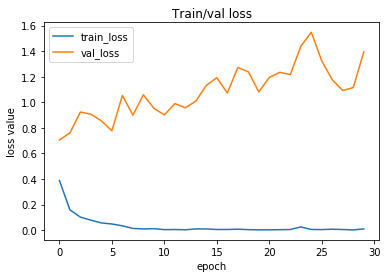

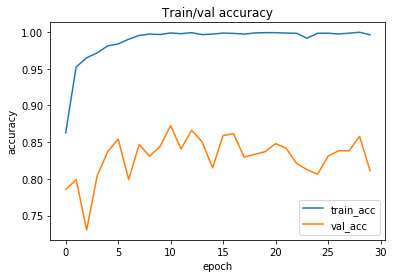

In [14]:
# Setup ResNet
model_resnet = models.resnet34(pretrained=True)
resnet_num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(resnet_num_ftrs, 10)
model_resnet = model_resnet.to(device)

run_name = 'resnet-adabound-lr0-001'

optimizer = adabound.AdaBound(model_resnet.parameters(), lr=1e-3, final_lr=0.1)
criterion = nn.CrossEntropyLoss()

# Train ResNet
trainer = Trainer_Helper(run_name, device)
trainer.setup_dataloader(train_dataloader, val_dataloader, test_dataloader)
trainer.train(model_resnet, optimizer, criterion, 30)

Training Results - Epoch: 1  Avg accuracy: 0.85 Avg loss: 0.40
Validation Results - Epoch: 1  Avg accuracy: 0.74 Avg loss: 0.90
Training Results - Epoch: 2  Avg accuracy: 0.96 Avg loss: 0.12
Validation Results - Epoch: 2  Avg accuracy: 0.83 Avg loss: 0.70
Training Results - Epoch: 3  Avg accuracy: 0.98 Avg loss: 0.05
Validation Results - Epoch: 3  Avg accuracy: 0.85 Avg loss: 0.63
Training Results - Epoch: 4  Avg accuracy: 0.96 Avg loss: 0.12
Validation Results - Epoch: 4  Avg accuracy: 0.82 Avg loss: 0.97
Training Results - Epoch: 5  Avg accuracy: 0.99 Avg loss: 0.03
Validation Results - Epoch: 5  Avg accuracy: 0.83 Avg loss: 0.82
Training Results - Epoch: 6  Avg accuracy: 0.99 Avg loss: 0.02
Validation Results - Epoch: 6  Avg accuracy: 0.87 Avg loss: 0.63
Training Results - Epoch: 7  Avg accuracy: 0.98 Avg loss: 0.04
Validation Results - Epoch: 7  Avg accuracy: 0.87 Avg loss: 0.96
Training Results - Epoch: 8  Avg accuracy: 0.99 Avg loss: 0.02
Validation Results - Epoch: 8  Avg accura

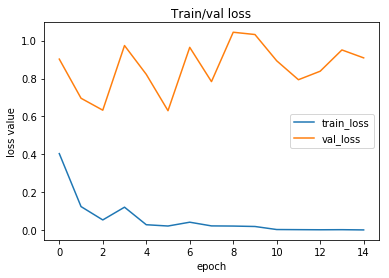

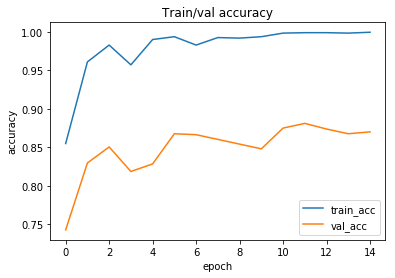

In [34]:
# Setup Densenet
model_densenet = models.densenet121(pretrained=True)
densenet_num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(densenet_num_ftrs, 10)
model_densenet = model_densenet.to(device)

run_name = 'densenet-adabound-fixed2'

optimizer = adabound.AdaBound(model_densenet.parameters(), lr=1e-3, final_lr=0.1)
criterion = nn.CrossEntropyLoss()

# Train Densenet
trainer = Trainer_Helper(run_name, device)
trainer.setup_dataloader(train_dataloader, val_dataloader, test_dataloader)
trainer.train(model_densenet, optimizer, criterion, 15)

In [8]:
total = 0

resnet_correct = 0
densenet_correct = 0

# Setup Resnet
model_resnet = models.resnet34(pretrained=True)
resnet_num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(resnet_num_ftrs, 10)
model_resnet = model_resnet.to(device)

# Setup Densenet
model_densenet = models.densenet121(pretrained=True)
densenet_num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(densenet_num_ftrs, 10)
model_densenet = model_densenet.to(device)

model_resnet_filepath = 'saved_models/resnet_adabound_best_val=87_3.pth'#'models_checkpoints/resnet-adabound-lr0-001_model_11_val_accuracy=87.2549.pth'
model_densenet_filepath = 'saved_models/densenet_adabound_best_val=88_1.pth'#'models_checkpoints/densenet-adabound-fixed2_model_12_val_accuracy=88.11275.pth'

model_resnet.load_state_dict(torch.load(model_resnet_filepath))
model_densenet.load_state_dict(torch.load(model_densenet_filepath))

model_resnet.eval()
model_densenet.eval()

with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device)
        resnet_out = model_resnet(imgs)
        densenet_out = model_densenet(imgs)
        _, resnet_pred = torch.max(resnet_out.data, 1)
        _, densenet_pred = torch.max(densenet_out.data, 1)
        total += labels.size(0)
        resnet_correct += (resnet_pred.cpu() == labels).sum().item()
        densenet_correct += (densenet_pred.cpu() == labels).sum().item()

print('Resnet Test Accuracy: {}'.format(100.0*resnet_correct/total))
print('Densenet Test Accuracy: {}'.format(100.0*densenet_correct/total))

Resnet Test Accuracy: 81.95937873357228
Densenet Test Accuracy: 84.10991636798089


Conclusion
===========

When switching from the relative simple CNN to Resnet or Densenet the test accuracy jumps from **81.8%** to **81.9%** and **84.1%** respectivly.
Overall this approach seems to deliver very good results.